# Review analysis to find potential improvement for customer satisfacition

The general idea is to analyse hotel reviews to find negative topics for which can be used to improve customer satisfaction. 

We will explore two ways:

1. First we analyse the whole data set and evaluate how good the topics are and check if the sentiment is negative.
2. Train a sentiment model to classify the reviews into positive and complaints and perform LDA afterwards.

The hypothesis is that the first approach will provide more general topics. When writing a positive review people tend to write more general, since everything was just nice. While when you complain about something since it was bad you will mention it more accurately in your review. 
Therefore, the second approach should provide more specific topics for the negative features of the hotels.

We have to be caution with the overall results because the dataset contains reviews for different hotels, resorts, and hostels from TripAdvisor hence the data is not really homogeneous which will add topics for different kind of hotels. 

## Structure

1. [Prerequisite and](#1.0)
2. [Data investigation](#2.0)
3. [First approach](#3.0)
    * [Model estimation](#3.1)
    * [Topic exploration](#3.2)
4. [Second approach](#4.0)
    * [Model estimation](#4.1)
    * [Topic exploration](#4.2)

<a id='1.0'></a>
## 1.0 Prerequisite

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Data processing
from LDA_preprocessing import *
from sklearn.model_selection import train_test_split
from gensim.models import CoherenceModel

# Data Visualisation
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
import matplotlib.colors as mcolors
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline

In [2]:
#Load the data set
data_all = pd.read_csv("Data/tripadvisor_hotel_reviews.csv")

<a id='2.0'></a>
## 2.0 Data invetigation

In [3]:
data_all.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [4]:
data_all['Review'].count()

20491

We will add the lenght of the review as features to the data as well as the polarity based on the rating. 

In [5]:
# calculate string length
data_all['n_characters'] = data_all['Review'].str.len()
# calculate number of tokens for each review
data_all['ntokens'] = data_all['Review'].str.split().str.len()

data_all.describe().T

,count,mean,std,min,25%,50%,75%,max
Rating,20491.0,3.952223,1.233030,1.0,3.0,4.0,5.0,5.0
n_characters,20491.0,724.896833,689.101024,44.0,339.0,537.0,859.0,13501.0
ntokens,20491.0,104.375824,100.656586,7.0,48.0,77.0,124.0,1931.0


In [5]:
data_all.query("n_characters>=50")
data_all.nsmallest(20, 'n_characters')

,Review,Rating,n_characters,ntokens
1501,"loved resort amazing space lot, not bored,",5,44,7
18073,"nice hotel view second room room left row,",5,44,8
488,"issues n't say 4 star service great pool bar,",3,47,9
13994,decent place stay price bed right bathroom max...,3,55,9
9969,"nice odd nice place stay, just buddies seeing ...",3,60,10
10446,glad stayed great experience stay time steps p...,4,61,9
2332,big price small room price hype expect sooooo ...,3,62,10
15273,nice hotel fight room good view view room fina...,4,62,11
16736,clean hotel attentive welcoming staff infinity...,4,64,9
18723,"great place stay, happy stay, weak dollar thou...",5,64,10


In [6]:
data_all.query("ntokens>=10")
data_all.nsmallest(20, 'ntokens')

,Review,Rating,n_characters,ntokens
1501,"loved resort amazing space lot, not bored,",5,44,7
18073,"nice hotel view second room room left row,",5,44,8
488,"issues n't say 4 star service great pool bar,",3,47,9
4524,"feeling cheated, westin signature comfy bed wi...",4,66,9
10446,glad stayed great experience stay time steps p...,4,61,9
13994,decent place stay price bed right bathroom max...,3,55,9
16736,clean hotel attentive welcoming staff infinity...,4,64,9
16969,"number hotel number ranking, perfect way, best...",5,65,9
1022,good location nice close shopping union square...,3,67,10
2195,liked location shuttle bring downtown convenie...,4,75,10


In [6]:
# Make a Polarity Rating where 3 = neutral, below negative and above positive
data_all['Rating_Polarity'] = data_all['Rating'].apply(lambda x: 'Positive' if x > 3 else('Neutral' if x == 3  else 'Negative'))

In [25]:
data_all.head()

,Review,Rating,n_characters,ntokens,Rating_Polarity
0,nice hotel expensive parking got good deal sta...,4,593,87,Positive
1,ok nothing special charge diamond member hilto...,2,1689,250,Negative
2,nice rooms not 4* experience hotel monaco seat...,3,1427,217,Neutral
3,"unique, great stay, wonderful time hotel monac...",5,600,89,Positive
4,"great stay great stay, went seahawk game aweso...",5,1281,191,Positive


 Lets take a first look at the numbers for the rating and the polarity.

In [ ]:
data_all[data_all['ntokens'] <=50]['Review'].count()/data_all['Review'].count()*100

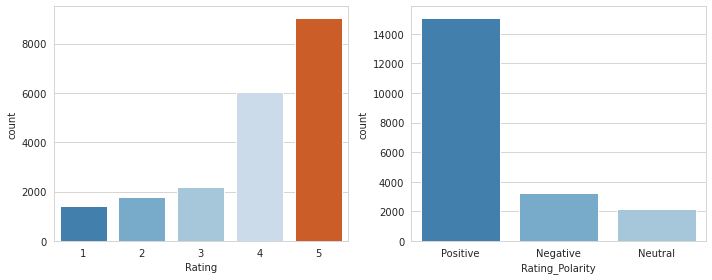

In [26]:
f = plt.figure(figsize=(10, 4))
gs = f.add_gridspec(1, 2)

with sns.axes_style("whitegrid"):
    ax = f.add_subplot(gs[0, 0])
    sns.countplot(x='Rating',data=data_all, palette = 'tab20c')

with sns.axes_style("whitegrid"):
    ax = f.add_subplot(gs[0, 1])
    sns.countplot(x='Rating_Polarity',data=data_all, palette = 'tab20c')

f.tight_layout()

Lets check the number of reviews with 50 tokens or less, which could be potential noise. The proportion in the negative and neutral polarity are small compared to the positive. 

In [36]:
data_all[data_all['ntokens'] <=50][['Rating_Polarity','Review']].groupby('Rating_Polarity').count()

,Review
Rating_Polarity,
Negative,628
Neutral,476
Positive,4489


In [35]:
# Showing the percantage of reviews with 50 tokens or less of the whole datased groupbed by polarity

data_all[data_all['ntokens'] <=50][['Rating_Polarity','Review']].groupby('Rating_Polarity').count()/len(data_all)*100

,Review
Rating_Polarity,
Negative,3.064760
Neutral,2.322971
Positive,21.907179


Let's digg a bit deeper into each polarity and analyse the token lenght, so we can judge if there is a difference in token lenght for positive and negative reviews.

In [99]:
data_all[data_all['Rating_Polarity'] == 'Negative'].describe().T

,count,mean,std,min,25%,50%,75%,max
Rating,3214.0,1.557872,0.496717,1.0,1.0,2.0,2.0,2.0
n_characters,3214.0,823.909459,721.085124,74.0,394.0,616.0,991.0,7802.0
ntokens,3214.0,120.307094,104.846676,10.0,58.0,90.0,145.0,1109.0


In [100]:
data_all[data_all['Rating_Polarity'] == 'Positive'].describe().T

,count,mean,std,min,25%,50%,75%,max
Rating,15093.0,4.599881,0.489939,4.0,4.0,5.0,5.0,5.0
n_characters,15093.0,695.163851,671.178864,44.0,326.0,514.0,821.0,12738.0
ntokens,15093.0,99.488571,97.993089,7.0,46.0,73.0,118.0,1755.0


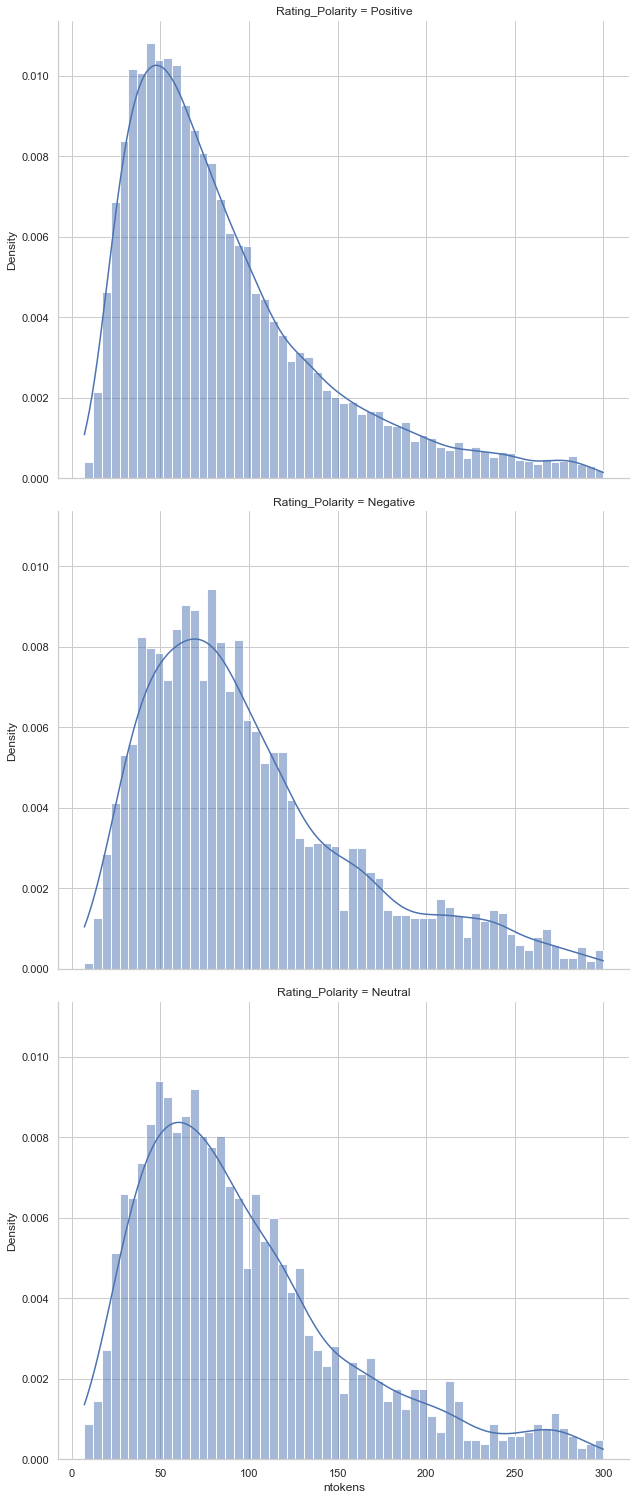

In [117]:
sns.set_theme(style="whitegrid")
sns.displot(
    data_all[data_all['ntokens'] <=300], x="ntokens",stat="density",  kde = True, row ='Rating_Polarity',common_norm=False,
    height=7, aspect=9/7)

The dataset contains 20491 reviews which we first analysed for their length. The reviews are mostly long with a mean of 104.37 tokens, including punctuations, and a median of 77. Even the minimum is at 7.0 tokens. Which is a good foundation since the Latent Dirichlet Allocation (LDA) performs good on medium or large sized texts compared to short texts (< 50 words). Where short Text Topic Models (STTM) as Gibbs Sampling Dirichlet Mixture Model (GSDMM) tend to perform better. In our case, roughly 27.29% of the reviews have 50 token or less. 

We have to make sure that the review length of the dataset is not too small when splitting the data into negative/positive and analysing them separately.
Our first results show, positive reviews tend to be shorter in the median (73.0) and average (99.488571) compared to negative (median: 90.0, average: 120.307094) ones. The standard deviation is also smaller indicating a support for the hypothesis that positive reviews are likely more general and standard.  

The proportion of the reviews having 50 token or less and being the negative is 11.22% (628). This accounts for 19.53% of the negative reviews from the whole dataset.
When doing the split on the dataset we have to keep the negative reviews, with 50 token or less, in mind and investigate if it yields better results dropping or keeping them, since they could be noisy to the LDA algorithm.

<a id='3.0'></a>
## 3. First approach

The first approach is to estimate the LDA model based on the whole data set. We split the dataset in train and test, where the test includes 5 reviews which will be unseen by the algorithm.

In [7]:
X_train, X_test = train_test_split(data_all[['Review', 'Rating','Rating_Polarity']], test_size=5, 
                                   random_state=1)
print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

Train size: (20486, 3)
Test size: (5, 3)


<a id='3.1'></a>
### 3.1 Model Estimation

The calculation takes a bit of time!!

First we test the coherence score for bigram and trigram to evaluate the best semantic input. Afterwards, we estimate the LDA model with different hyperparameter for one of the semantic inputs.
Coherence measures the relative distance between words within a topic. We use the C_V coherence score which is typically 0 < x < 1.

The results of the calculation were saved in the coh_mat.json in the data subfolder since the calculation is computer intensive and taking time. Furthermore, the results are plotted in the graph below.

In [ ]:
coh_mat = pd.DataFrame(index=range(0,30),columns=['bi_gram', 'tri_gram'], dtype='float')
mod = ['bi_gram','tri_gram']

for i in mod:
    results = lda_processing(X_train['Review'], model = i)
    corpus = results['text_corpus']
    id2word = results['id2word']
    texts = results['data_output']


    for x in range(1, 30):
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics= x,
                                               random_state=100,
                                               update_every=1,
                                               chunksize=100,
                                               passes=10,
                                               alpha='auto',
                                               per_word_topics=True)
        cm = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
        coh_mat[i][x] = cm.get_coherence()

In [44]:
# Saving the coherence matrix for future use
#coh_mat.to_json(r'C:\Users\unters1\Desktop\Projekt\NLP\Topic Analysis\Data\coh_mat.json')
coh_mat = pd.read_json(r'C:\Users\unters1\Desktop\Projekt\NLP\Topic Analysis\Data\coh_mat.json')

In the following graph we can see that the highest coherence score (around 0.42) was achieved for the bi_gram model with 7 topics.

In general a coherence score of 0.42 is considered low. Which indicates that at least of the following things must be true:
1. The number of topics is still not ideal.
2. Fine-tuning the models Hyperparameter is still not optimal (alpha, random_state)
3. Or the data is not optimal / noisy.

These points we need to address later to achieve a score between 0.55 and 0.7 which is good. 

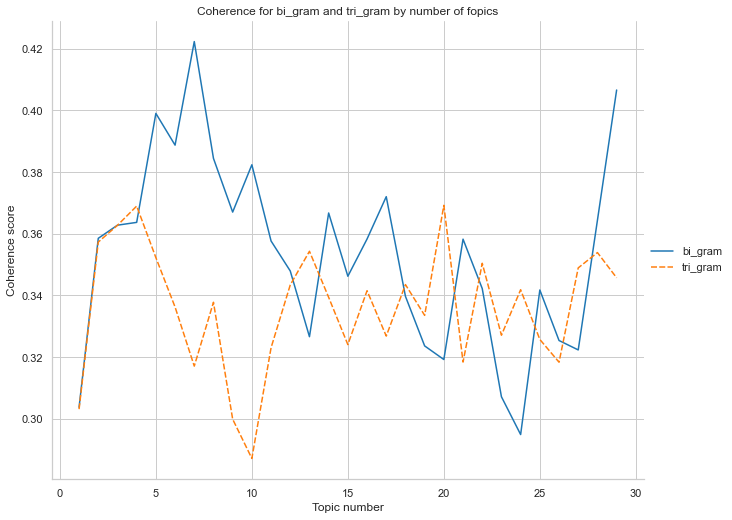

In [56]:
sns.relplot(data=coh_mat, kind="line", height=7, aspect=9/7)
plt.title("Coherence for bi_gram and tri_gram by number of fopics")
plt.ylabel("Coherence score")
plt.xlabel("Topic number")
sns.set_style('whitegrid')

In [75]:
results = lda_processing(X_train['Review'], model = 'bi_gram')
corpus = results['text_corpus']
id2word = results['id2word']
texts_lemma = results['data_output']

In [18]:
# Topics range
min_topics = 11
max_topics = 15
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.1))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.1))
beta.append('symmetric')

model_results = {'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
    
# iterate through number of topics
for k in topics_range:
    print(k)
    # iterate through alpha values
    for a in alpha:
        # iterare through beta values
        for b in beta:
            # get the coherence score for the given parameters
            cv = compute_coherence_values(corpus=corpus, text= texts_lemma, dictionary=id2word, k=k, a=a, b=b)
            # Save the model results
            model_results['Topics'].append(k)
            model_results['Alpha'].append(a)
            model_results['Beta'].append(b)
            model_results['Coherence'].append(cv)

11
12


KeyboardInterrupt: 

In [17]:
df = pd.DataFrame(model_results)[pd.DataFrame(model_results)['Coherence'] == pd.DataFrame(model_results)['Coherence'].max()]
df

,Topics,Alpha,Beta,Coherence
397,12,0.01,0.11,0.509275


In [10]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics= 13,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.41,
                                           eta =0.21,
                                           per_word_topics=True)

<a id='3.2'></a>
### 3.2 Topic exploration

We can visualize the different topics after calculating the model 

1. pyLDAvis is used to visualize the topics interactively.
2. Word Cloud for each topic.
3. Assigning topic names for each topic.

The pyLADvis graph shows the topics in a two-dimensional space. The lambda is a relevance parameter to adjust the weights given to a term in the topic. Setting lambda between 0.2 and 0.4 often helps to generate interpretable topics.

In [12]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.241545 -0.082062       1        1  20.346609
12    -0.233544  0.067747       2        1  16.703118
5     -0.283055 -0.048385       3        1  16.639618
2     -0.279239  0.059492       4        1  14.833238
7     -0.159475  0.081902       5        1   9.583735
1     -0.121988 -0.020490       6        1   7.064512
6      0.076500 -0.339374       7        1   3.989035
0      0.087412  0.205771       8        1   3.697865
8      0.227941  0.002846       9        1   1.574359
4      0.229955  0.015401      10        1   1.500393
3      0.229368  0.021252      11        1   1.498667
11     0.232948  0.020823      12        1   1.313427
10     0.234722  0.015076      13        1   1.255427, topic_info=            Term          Freq         Total Category  logprob  loglift
40         hotel  42581.000000  42581.000000  Default  30.0000  30.0000
66          room  44444.000000  44444.000000  Default  29.0000  29.0000
166         stay  24754.000000  24754.000000  Default  28.0000  28.0000
38         great  19220.000000  19220.000000  Default  27.0000  27.0000
37          good  20248.000000  20248.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
430      caution     94.137586     96.722738  Topic13  -5.3437   4.3506
4505  disapointe     92.324314     94.880835  Topic13  -5.3631   4.3504
2148        baby    179.293076    253.908803  Topic13  -4.6994   4.0297
1623          ok    173.025563    505.033881  Topic13  -4.7350   3.3065
462        dream    105.038630    173.617299  Topic13  -5.2341   3.8752

[676 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
1320      6  0.985575     acceptable
2141     11  0.991172  accommodation
656      11  0.994039   accomodation
356       2  0.997219       activity
2222     10  0.990652       addition
...     ...       ...            ...
2295      7  0.985002        worried
1664      1  0.993679          worry
901       1  0.996773          wrong
843       7  0.999234           year
1801     10  0.995399          young

[1070 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 13, 6, 3, 8, 2, 7, 1, 9, 5, 4, 12, 11])

IndexError: list index out of range

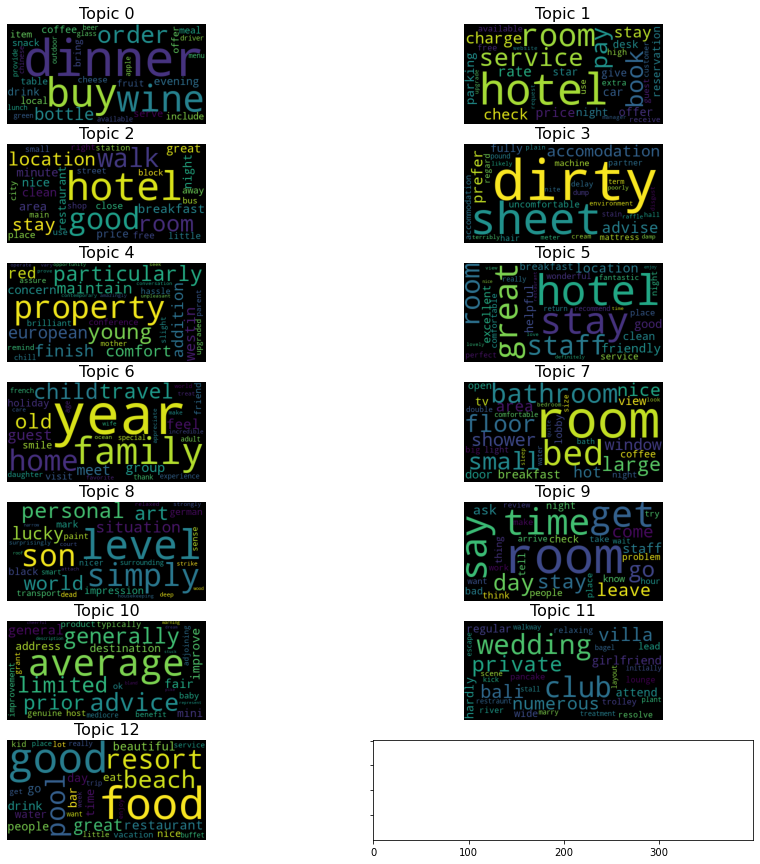

In [13]:
# 1. Wordcloud of Top N words in each topic

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(num_topics=13, num_words=10, formatted=False)

fig, axes = plt.subplots(7, 2, figsize=(15,15),sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    plt.gca().imshow(WordCloud().fit_words(dict(lda_model.show_topic(i, 30))))
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [14]:
# Print all the topics

topics = []
for topic_id in range(lda_model.num_topics):
    topk = lda_model.show_topic(topic_id, 15)
    topk_words = [ w for w, _ in topk ]
    topics.append([topic_id, ' '.join([ w for w, _ in lda_model.show_topic(topic_id, 10)])])
    print('{}: {}'.format(topic_id, ' '.join(topk_words)))
topics = pd.DataFrame(topics, columns =['Topic_id', 'Topic_words'])

0: dinner buy wine order bottle evening drink serve coffee item table offer snack local include
1: hotel room service book pay charge stay check rate price parking offer car night reservation
2: hotel good walk room location stay breakfast great minute nice area clean night restaurant price
3: dirty sheet accomodation advise prefer fully uncomfortable accommodation machine regard hair partner mattress delay term
4: property young particularly european finish comfort maintain addition red westin concern conference brilliant hassle chill
5: hotel stay great staff room location friendly good helpful excellent clean breakfast service wonderful comfortable
6: year family home child travel old guest meet feel group holiday smile visit friend daughter
7: room bed bathroom small floor large shower nice window area hot breakfast view door tv
8: level simply son personal world art lucky situation impression black german mark transport paint nicer
9: room say time get day go stay leave come staff

Next we need to manually assign the topic names for each topic and then add the topics and their probabilities to each review.

In [15]:
#Manual assignment of the topics
topics = pd.DataFrame(topics, columns =['Topic_id', 'Topic_words'])
topics['Topic_name'] =['Outdoor Tour','Parking fee','Location / Access','Accomodation (dirty)', 'Property','Staff / Service',
                       'Family trip','Room / Furniture','Impression','Complaint handling','Average appraisal','Wedding / Honeymoon','Restaurant / Bar']
topics

,Topic_id,Topic_words,Topic_name
0,0,dinner buy wine order bottle evening drink ser...,Outdoor Tour
1,1,hotel room service book pay charge stay check ...,Parking fee
2,2,hotel good walk room location stay breakfast g...,Location / Access
3,3,dirty sheet accomodation advise prefer fully u...,Accomodation (dirty)
4,4,property young particularly european finish co...,Property
5,5,hotel stay great staff room location friendly ...,Staff / Service
6,6,year family home child travel old guest meet f...,Family trip
7,7,room bed bathroom small floor large shower nic...,Room / Furniture
8,8,level simply son personal world art lucky situ...,Impression
9,9,room say time get day go stay leave come staff,Complaint handling


In [76]:
cv = compute_coherence_values(corpus=corpus, text= texts_lemma, dictionary=id2word, k=13, a=0.41, b=0.21)

TypeError: compute_coherence_values() got an unexpected keyword argument 'corpus'

In [ ]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts_lemma, dictionary=id2word, coherence='c_v')

In [ ]:
coherence_model_lda.get_coherence_per_topic()

In [29]:
# Adding the probable topics to the data
X_train['top1'] = X_train['Review'].apply(lambda x: lda_get_topics(lda_model, x, topics, topic_order = 0))
X_train['top1_prob'] = X_train['Review'].apply(lambda x: lda_get_prob(lda_model, x, topics, topic_order = 0))
X_train['top2'] = X_train['Review'].apply(lambda x: lda_get_topics(lda_model, x, topics, topic_order = 1))
X_train['top2_prob'] = X_train['Review'].apply(lambda x: lda_get_prob(lda_model, x, topics, topic_order = 1))
X_train['top3'] = X_train['Review'].apply(lambda x: lda_get_topics(lda_model, x, topics, topic_order = 2))
X_train['top3_prob'] = X_train['Review'].apply(lambda x: lda_get_prob(lda_model, x, topics, topic_order = 2))

Printing the relative number of topics of the shows that for the most probable topic we mainly have the Hotel_Stay topic. Only we see variation when looking at the second and third most probable. This makes sense since we analysed reviews. But it provides less meaningful insights.

In [18]:
X_train.head()

,Review,Rating,Rating_Polarity,top1,top1_prob
15901,exceed expectation tokyo vacation 4-13 october...,5,Positive,Location / Access,0.257747
3661,loved dominicana family 6 adults children ages...,4,Positive,Staff / Service,0.230389
2124,excellent choice stayed airport hilton night a...,5,Positive,Location / Access,0.344944
17544,wonderful stay midtown stayed 3 nights 4 days ...,5,Positive,Staff / Service,0.548587
82,"great stay elevators, agree previous posts hot...",5,Positive,Complaint handling,0.301715


C:\Users\unters1\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


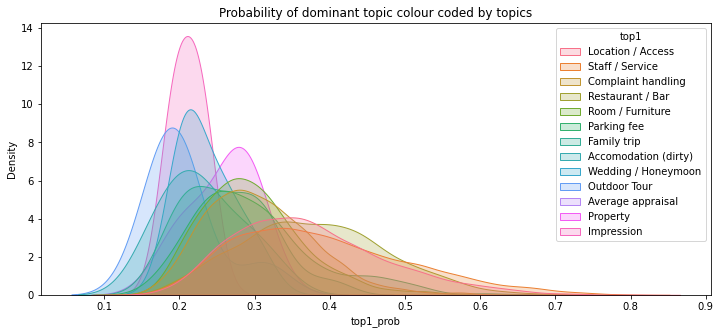

In [19]:
plt.figure(figsize=(12,5))
sns.kdeplot(data=X_train, x='top1_prob', hue='top1', shade=True, 
            common_norm=False)
plt.title("Probability of dominant topic colour coded by topics");

From this graph we can see, that th algorithm does not asign a high probability for the most probable topic. He is not so sure about the topic. We have 13 topics and the propability is not centered around a higher value. It leads to the conclusion that most of the topics are more general and therefore including several topics. 

In [68]:
X_train[X_train['Rating_Polarity'] == 'Negative'].loc[:, ['Review', 'top1']].groupby("top1").count()

,Review
top1,
Accomodation (dirty),7
Complaint handling,1292
Family trip,15
Location / Access,465
Parking fee,411
Restaurant / Bar,461
Room / Furniture,362
Staff / Service,200
Wedding / Honeymoon,1


In [69]:
X_train[X_train['Rating_Polarity'] == 'Negative'].loc[:, ['Review', 'top2']].groupby("top2").count()

,Review
top2,
Accomodation (dirty),19
Average appraisal,7
Complaint handling,960
Family trip,37
Impression,14
Location / Access,397
Outdoor Tour,15
Parking fee,587
Property,7


In [72]:
X_train[(X_train['Rating_Polarity'] == 'Negative') & (X_train['top1_prob'] == X_train['top2_prob'])]

,Review,Rating,Rating_Polarity,top1,top1_prob,top2,top2_prob,top3,top3_prob


C:\Users\unters1\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


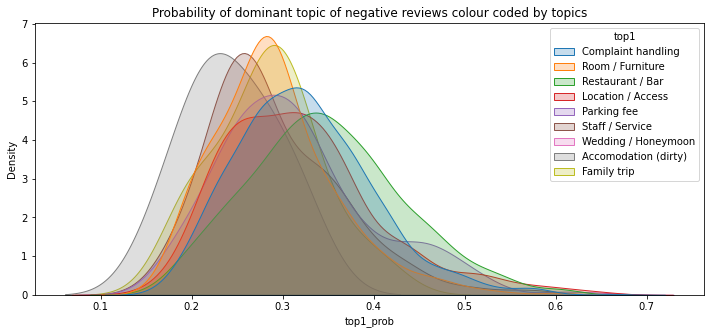

In [73]:
plt.figure(figsize=(12,5))
sns.kdeplot(data=X_train[X_train['Rating_Polarity'] == 'Negative'], x='top1_prob', hue='top1', shade=True, 
            common_norm=False)
plt.title("Probability of dominant topic of negative reviews colour coded by topics");

We can see the topics with the most negative reviews by showing the proportion of the topics from negative reviews of all negative reviews.
Where the graph indicates that overall the topics could be allocated a bit better since the propabilities shifted more to the right.

In [259]:
X_test

,Review,Rating,Rating_Polarity
15077,great location value cautious staying hotel lo...,5,Positive
2784,2nd trip paradisus 2nd time paradisus 10 year ...,4,Positive
5018,"best staff, husband stayed hotel casci nights,...",4,Positive
2741,honeymoon wife stayed week august 2001 honeymo...,4,Positive
8327,"perfect location location location location, w...",3,Neutral


In [22]:
X_test['Review'][2784]

"2nd trip paradisus 2nd time paradisus 10 year wedding anniversary, went riu years ago decided really wanted paradisus 2001, let start saying bahamas caymen islands hotel beautifully landscaped hotels, pool gorgeous plenty areas away, tucked away nooks place, people unbelievably friendly happy, no question language barrier country, quick tips good things disappointments, 1. arrive airport porters swarm bags, let bags carry feet want tip, thing return airport hotel, time insist carry bags feet.2, 2 times punta cana taken pepto tablets, morning just safe problems, time forgot bring antacid, 8 days day 7 got montazuma-it 2 days feeling affects, advice antacid tablets-i got bad heartburn day pepto tablet morning feel alright.3, got great advice reviewer bring chill cups drinks, got migo plastic chill cups straws target fewer trips beach bars 4, bring cork screw, ordered bottle wine room heading beach, wine returned no cork screw, room service got shower did n't leave, time got heading door

In [23]:
lda_get_topics(lda_model, X_test['Review'][2784], topics, topic_order = 0)

'Complaint handling'

In [24]:
lda_get_prob(lda_model, X_test['Review'][2784], topics, topic_order = 0)

0.2846112847328186

In [25]:
lda_get_topics(lda_model, X_test['Review'][2784], topics, topic_order = 1)

'Restaurant / Bar'

In [26]:
lda_get_prob(lda_model, X_test['Review'][2784], topics, topic_order = 1)

0.26967528462409973

In [27]:
lda_get_topics(lda_model, X_test['Review'][2784], topics, topic_order = 2)

'Room / Furniture'

In [28]:
lda_get_prob(lda_model, X_test['Review'][2784], topics, topic_order = 2)

0.07474282383918762

<a id='4.0'></a>
## 4. Second approach

In this approach we use the Rating_Polarity feature to separate the data and use only the negative to train the topic model.
First we use the whole negative dataset and check if the results differ when dropping the reviews with <50 tokens.